<a href="https://colab.research.google.com/github/kumarchandan/100days/blob/master/Unit-5/EVA4_S5_Iteration_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Assignment**

Target is:
- 99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
- Less than or equal to 15 Epochs
- Less than 10000 Parameters


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

> **Dataset and Creating Train/Test Split**

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


> **Dataloader Arguments & Test/Train Dataloaders**

In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


> **Data Statistics**

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


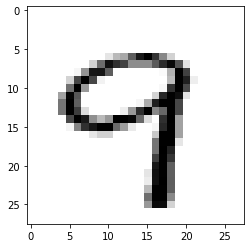

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

> **More**  

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

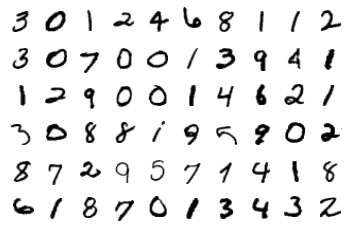

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

> **How did we get those mean and std values which we used above?**

Let's run a small experiment.

In [0]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


> **The Model**

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),   # in=28, out=28 , rf=3
            nn.ReLU(),
                        
            nn.Conv2d(8, 16, 3, padding=1),  # in=28, out=28,  rf=5
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2),              # in=28, out=14,  rf=10
        )

        # Second Conv block
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), # in=14 out=14, rf=12
            nn.ReLU(),
            
            
            nn.Conv2d(32, 64, 3, padding=1), # in=14, out=14, rf=14
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2),              # in=14, out=7, rf=28
        )

        # Third Conv Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 32, 3),           # in=7, out=5, rf=30
            nn.ReLU(),
            
            nn.Conv2d(32, 10, 5),            # in=5, out=3, rf=32
            # nn.ReLU(),

            # nn.Conv2d(16, 10, 3),            # in=3, out=1, rf=32
        )          

    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)

      x = x.view(-1, 10)
      x = F.log_softmax(x)
      return x


> **Model Params**

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           1,168
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           4,640
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
              ReLU-9           [-1, 64, 14, 14]               0
        MaxPool2d-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 32, 5, 5]          18,464
             ReLU-12             [-1, 32, 5, 5]               0
           Conv2d-13             [-1, 10, 1, 1]           8,010
Total params: 50,858
Trainable params: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


> **Training and Testing**

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Train
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

# Test
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.08197415620088577 Batch_id=468 Accuracy=81.62: 100%|██████████| 469/469 [00:11<00:00, 41.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0853, Accuracy: 9740/10000 (97.40%)

EPOCH: 1


Loss=0.03340083360671997 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:11<00:00, 41.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.061867643147706985 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:11<00:00, 41.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9828/10000 (98.28%)

EPOCH: 3


Loss=0.030043037608265877 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 41.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9863/10000 (98.63%)

EPOCH: 4


Loss=0.004941036459058523 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:11<00:00, 41.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9881/10000 (98.81%)

EPOCH: 5


Loss=0.00831844937056303 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 41.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9883/10000 (98.83%)

EPOCH: 6


Loss=0.08406022191047668 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 41.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9888/10000 (98.88%)

EPOCH: 7


Loss=0.04474383220076561 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:11<00:00, 41.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.005982319358736277 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 41.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9888/10000 (98.88%)

EPOCH: 9


Loss=0.020761290565133095 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:11<00:00, 41.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.02601788379251957 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:11<00:00, 41.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Loss=0.010969012975692749 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:11<00:00, 41.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


Loss=0.025616472586989403 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 42.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9887/10000 (98.87%)

EPOCH: 13


Loss=0.0021957755088806152 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:11<00:00, 41.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9888/10000 (98.88%)

EPOCH: 14


Loss=0.010360111482441425 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:11<00:00, 41.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9899/10000 (98.99%)

EPOCH: 15


Loss=0.003948877099901438 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:11<00:00, 42.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9889/10000 (98.89%)

EPOCH: 16


Loss=0.0011608401546254754 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:11<00:00, 41.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9900/10000 (99.00%)

EPOCH: 17


Loss=0.11218772083520889 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:11<00:00, 41.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9886/10000 (98.86%)

EPOCH: 18


Loss=0.0003563860955182463 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:11<00:00, 41.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9905/10000 (99.05%)

EPOCH: 19


Loss=0.0005896389484405518 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:11<00:00, 41.73it/s]



Test set: Average loss: 0.0443, Accuracy: 9896/10000 (98.96%)



Text(0.5, 1.0, 'Test Accuracy')

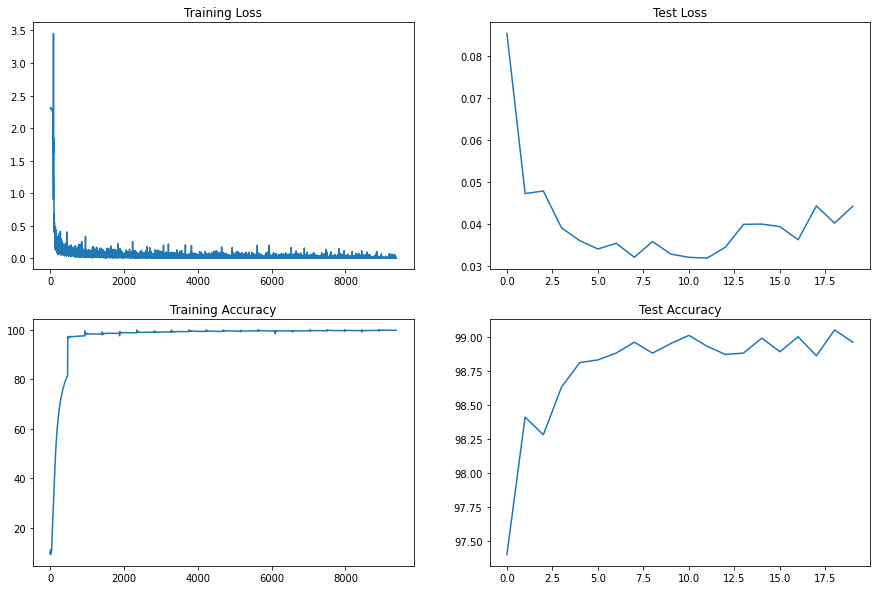

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")


> **Observation**

Target:  
1. Setting up basic skeleton
2. Results:
  1. Parameters: 50.8 K
  2. Best Train Accuracy: 99.83
  3. Best Test Accuracy: 99.05
3. Analysis:
  1. Numbers of parameters are more than what is asked.
  2. The model is over-fitting. The gap b/w train and test is bigger.